### Loading libraries and the data

In [1]:
#load xgboost module
! python -m pip install xgboost

In [2]:
#pacakges for preprocessing and feature selection
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

#packages for modelling
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, plot_confusion_matrix

In [3]:
#loading csv files
fulldata=pd.read_csv("cardiovascular study dataset/train1.csv")
#testdata=pd.read_csv("cardiovascular study dataset/test.csv")

#merge the two datasets
#fulldata=pd.concat([traindata,testdata],ignore_index=True)


In [4]:
fulldata.dtypes

id                   int64
age                  int64
education          float64
sex                 object
is_smoking          object
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

### Metadata and statistics

In [ ]:
traindata.shape

In [5]:
fulldata.shape

(3390, 17)

In [ ]:
fulldata.dtypes

In [6]:
fulldata.describe()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [ ]:
fulldata.info()

### Extracting independent variables

### Missing values

In [7]:
#identifying missing values 
print(fulldata.isnull().sum())

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64


In [8]:
#create a copy of dataframe for data cleaning
clean_data=fulldata.copy()

In [9]:
#BPMeds
#filling null values with next values in the column
clean_data['BPMeds'].fillna(method='bfill',inplace=True)

#totChol
#filling null values with mean
clean_data['totChol'].fillna(236.721585,inplace=True)

#glucose
#filling null values with median
clean_data['glucose'].fillna(78,inplace=True)

#BMI
#filling null values with mean
clean_data['BMI'].fillna(25.802008,inplace=True)

#cigsPerDay
#interpolation for missing values
clean_data['dailyCigs']=clean_data['cigsPerDay'].interpolate(method='polynomial',order=2,limit_direction='forward')

#heartrate
#filling null value with mean
clean_data['heartRate'].fillna(25.802008,inplace=True)

### Encoding categorical variables

In [10]:
#Checking for unique values

sex_values=clean_data['sex'].unique()
smoking_values=clean_data['is_smoking'].unique()

print(sex_values, smoking_values)

['F' 'M'] ['YES' 'NO']


In [11]:
#applying label encoding on 'sex' and 'is_smoking' variables

encoder1=preprocessing.LabelEncoder()
clean_data['encoded_sex']=encoder1.fit_transform(clean_data['sex'])

encoder2=preprocessing.LabelEncoder()
clean_data['encoded_smoker']=encoder2.fit_transform(clean_data['sex'])
clean_data.head(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,dailyCigs,encoded_sex,encoded_smoker
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,25.802008,90.0,80.0,1,3.0,0,0
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.0,0,0.0,1,1
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.0,0,10.0,0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.0,1,20.0,1,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.0,0,30.0,0,0


### Feature selection

#### Dropping rows and columns

In [13]:
#Dropping columns not needed after encoding and imputing
data=clean_data.drop(columns=['cigsPerDay','education','id','sex','is_smoking'])

#drop the rows from original test set as no actual values exist for evaluation
data1=data.dropna(axis=0)
final_data=pd.DataFrame(data1)

In [14]:
#check missing values again
print(final_data.isnull().sum())


age                0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dailyCigs          0
encoded_sex        0
encoded_smoker     0
dtype: int64


### Define y data and x data

In [15]:
#drop the rows with empty target variable
y=final_data["TenYearCHD"].dropna()

#this creates a dataframe with 3390 rows
#define x data with the same rows

x=final_data[:3390].drop(columns=["TenYearCHD"])

### Data Exploration

#### Outliers

In [ ]:
#boxplots using seaborn

#numerical



In [ ]:
final_data

### Skewness and density plots

In [16]:
final_data.skew()

age                 0.225796
BPMeds              5.563972
prevalentStroke    12.297612
prevalentHyp        0.795189
diabetes            6.001977
totChol             0.946210
sysBP               1.175837
diaBP               0.718173
BMI                 1.024346
heartRate           0.653488
glucose             6.462108
TenYearCHD          1.953182
dailyCigs           1.222365
encoded_sex         0.271614
encoded_smoker      0.271614
dtype: float64

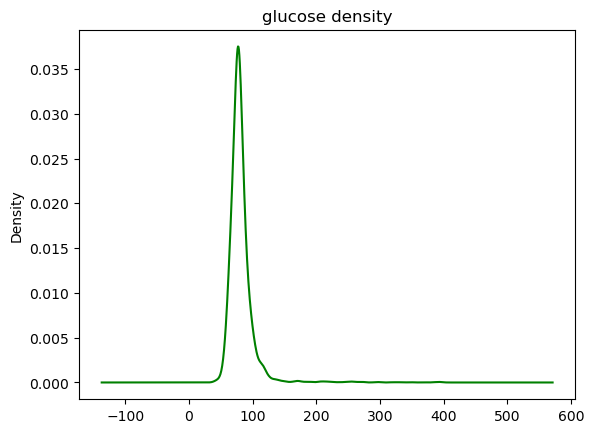

In [17]:
final_data.glucose.plot.density(color='green')
pyplot.title('glucose density')
pyplot.show()

In [ ]:
final_data.BMI.plot.density(color='pink')
pyplot.title("BMI density plot")
pyplot.show()

In [ ]:
final_data.dailyCigs.plot.density(color='purple')
pyplot.title("Daily Cigarettes density plot")
pyplot.show()

In [ ]:
final_data.prevalentStroke.plot.density(color='blue')
pyplot.title("Stroke prevalence")
pyplot.show()

In [ ]:
final_data.BPMeds.plot.density(color='orange')
pyplot.title("BP medication density plot")
pyplot.show()

#### Scatter plots

In [ ]:
#create a new dataset with only numeric data
numeric_data=final_data.drop(columns=['BPMeds','prevalentStroke','encoded_sex','encoded_smoker','prevalentHyp','diabetes'])
sns.pairplot(numeric_data,markers='x')
pyplot.show()

#### Correlation matrix

In [ ]:
corrMatrix=numeric_data.corr()
sns.heatmap(corrMatrix,annot=True,cmap="crest")
pyplot.show()

#### Histograms

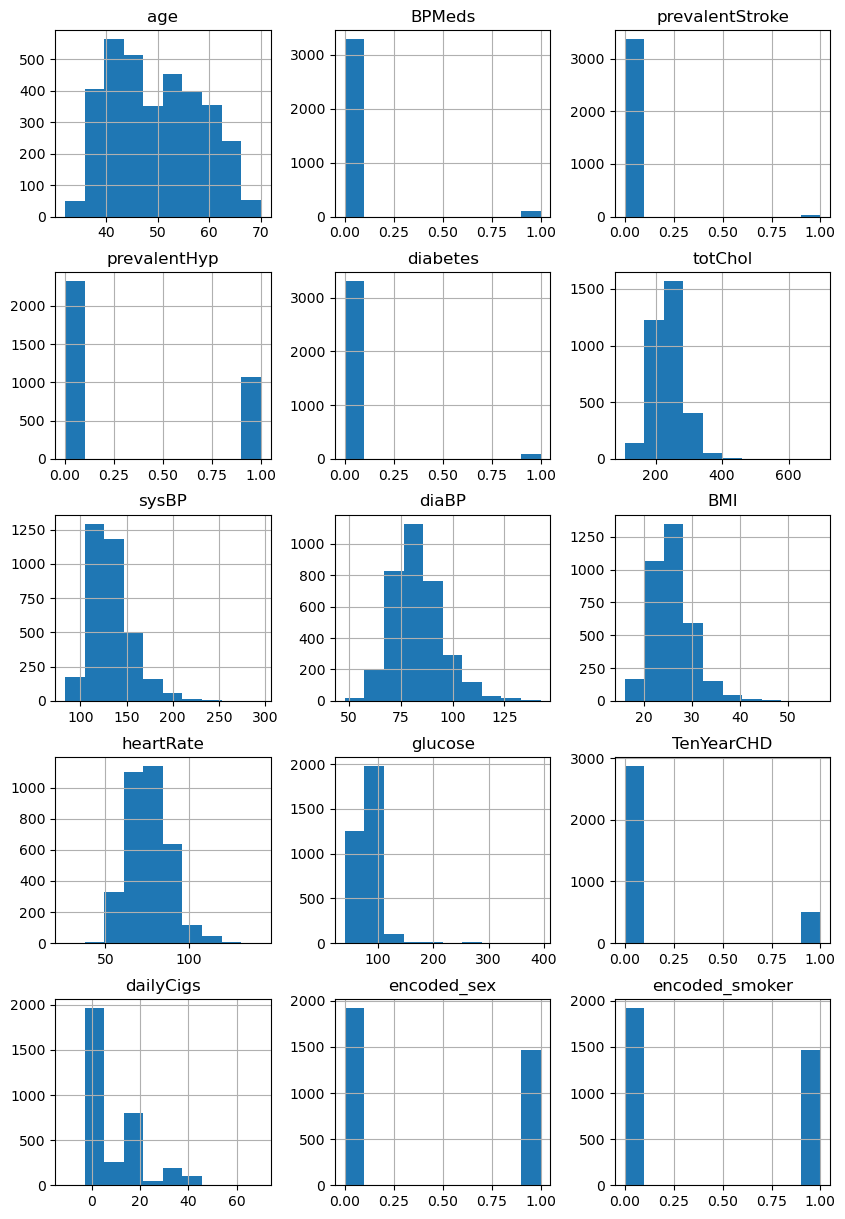

In [18]:
# distributions

final_data.hist(figsize=(10,15),layout=(5,3))
pyplot.show()

In [ ]:
sns.histplot(data=final_data,x="TenYearCHD",color="rebeccapurple")
pyplot.title("TenYearCHD distribution")
pyplot.show()

### Bivariate Analysis

In [ ]:
sns.histplot(data=clean_data,x="TenYearCHD",hue="is_smoking",multiple="stack")
pyplot.show()

In [ ]:
#distribution of CHD risk by sex
sns.histplot(data=clean_data,x="TenYearCHD",hue="sex",multiple="dodge")

In [ ]:
#distribution of BMI by sex

sns.histplot(data=clean_data,x="BMI",hue="sex")

In [ ]:
sns.histplot(data=clean_data,x="BMI",hue="TenYearCHD")
pyplot.legend(["none risk","CHD risk"])
pyplot.show()

In [ ]:
sns.histplot(data=clean_data,x="age",hue="TenYearCHD")
pyplot.legend(["none risk","CHD risk"])
pyplot.show()

In [ ]:
#box plots to observe the central tendency of the data
pyplot.figure(figsize=(15,10))
sns.boxplot(data=numeric_data,orient="h")
pyplot.title("Box and Whiskers Plot",fontsize=20)
pyplot.show()

In [ ]:
,
boxplot = final_data.boxplot(column=['totChol', 'glucose', 'BMI','age','sysBP','diaBP','heartRate','dailyCigs'],figsize=(10,8))


In [19]:
#BMI distribution

underweight=0
normal=0
overweight=0
obese=0

#count number of people for each category

for row in range(len(final_data)):
    if final_data.loc[row,"BMI"] <= 18.5:
        underweight+=1
    elif final_data.loc[row,"BMI"]>18.5 and final_data.loc[row,"BMI"]<=25:
        normal+=1
    elif final_data.loc[row,"BMI"]>25 and final_data.loc[row,"BMI"]<=30:
        overweight+=1
    else:
        obese+=1

#display values from the BMI classes   
print(underweight,normal,overweight,obese)
        
       

41 1512 1401 436


In [20]:
print(underweight,normal,overweight,obese)

41 1512 1401 436


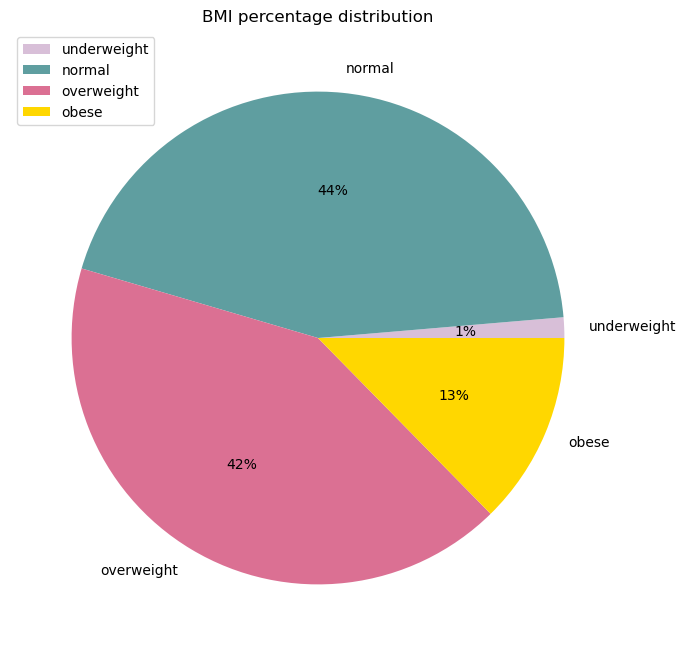

In [21]:
class_values=[57, 1869, 1776, 536]
bmi_class=["underweight","normal","overweight","obese"]
colors = ["thistle","cadetblue","palevioletred","gold"]
pyplot.figure(figsize=(8,8))
pyplot.pie(class_values, labels = bmi_class, colors = colors, autopct='%.0f%%')
pyplot.title("BMI percentage distribution")
pyplot.legend(loc="upper left")
pyplot.show()

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

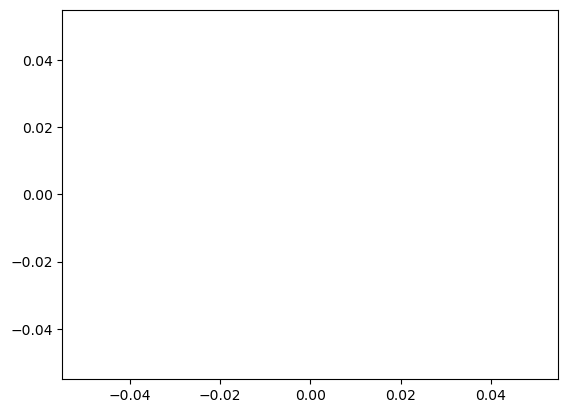

In [22]:
#glucose and diabetes line plot
#diabetes will be hue 

final_data["count"]=list(range(1,len(final_data)+1))

sns.lineplot(data=final_data,x="count",y="glucose",hue="diabetes")



### Feature importance

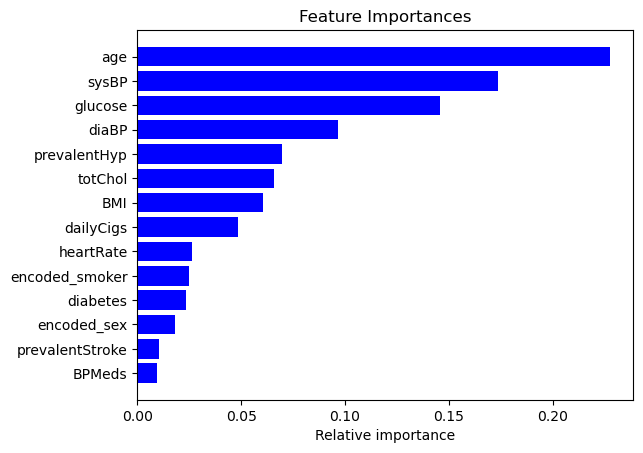

In [23]:
#feature importance

from sklearn.ensemble import RandomForestClassifier

#create a random forest model
rf_model=RandomForestClassifier(random_state=1,max_depth=4)

#fit the model random forest
rf_model.fit(x,y)

train_features=x.columns
importances=rf_model.feature_importances_
indices=np.argsort(importances)[-15:]
pyplot.title('Feature Importances')
pyplot.barh(range(len(indices)),importances[indices],color='b',align='center')
pyplot.yticks(range(len(indices)),[train_features[i] for i in indices])
pyplot.xlabel("Relative importance")

pyplot.show() 

In [ ]:
print(train_features)

In [ ]:
print(importances)

In [ ]:
pyplot.title('Feature Importances')
pyplot.barh(range(len(indices)),importances[indices],color='b',align='center')
pyplot.show() 

### Building an XGBoost model

In [24]:
X=x.loc[:,'age':'BMI'].drop(columns=["diaBP"])

In [25]:
#predictor data is x
#target value is y

#X=x.loc[:,'age':'BMI']
#splitting the data to train and test sample 85:15

X_train, X_test, y_train, y_test= train_test_split(X , y, test_size=0.3,random_state=693)

In [26]:
#declare parameters

params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
            
            
            
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [27]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test)

In [28]:
# check accuracy score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.8260


In [29]:
#print the confusion matrix for the first model
print(confusion_matrix(y_test, y_pred))

[[834  15]
 [162   6]]


#### Hyperparameter tuning

In [ ]:
#obtain values for target class. this is to determine a sclae_pos_weight for the model
y_train.value_counts()

In [ ]:
#adjust the scale_pos_weight hyperparameter due to imbalanced data




In [30]:
model_params = {
            'objective':'binary:logistic',
            'learning_rate': 1,
            'n_estimators':80
    
        }

# instantiate the classifier 
model = XGBClassifier()


# fit the classifier to the training data
model.fit(X_train, y_train)

# make predictions on test data
y_pred = model.predict(X_test)


# check accuracy score
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.8092


In [31]:
#print the confusion matrix for the first model
print(confusion_matrix(y_test, y_pred))


[[814  35]
 [159   9]]


C:\Users\kimb3\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


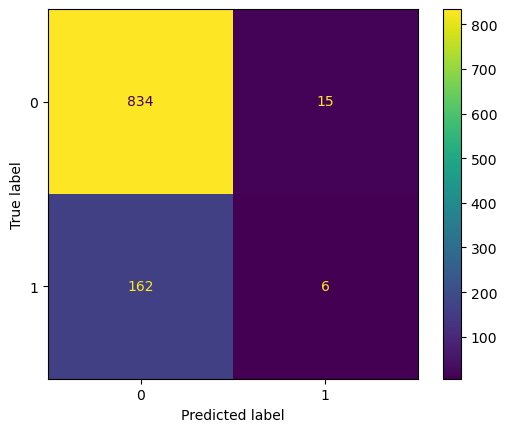

In [32]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgb_clf, X_test, y_test)  
pyplot.show() 